# Восстановление золота из руды

**Описание проекта**

Компания «Цифры» разрабатывает решения для эффективной работы промышленных предприятий.

**Цель проекта**

Требуется подготовить прототип модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды. 
В нашем распоряжении данные с параметрами добычи и очистки. 
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.


**План проекта**

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

**Описание данных**

*Технологический процесс*
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
  
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

*Параметры этапов*
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

*Наименование признаков*

Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]
Пример: rougher.input.feed_ag

*Возможные значения для блока [этап]:*
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

*Возможные значения для блока [тип_параметра]:*
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

## Подготовка данных

1.1 Откроем файлы и изучите их.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Хорошее оформление импортов! \
Импорты собраны в одной ячейке, сгрупированы по функциональности. Можно ещё разделить группы пустой строкой.</font>

In [2]:
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
pd.set_option('display.max_columns', None)
gold_recovery_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [4]:
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [5]:
gold_recovery_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,14117.000000,14149.000000,14049.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14149.000000,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000,14120.000000,14141.000000,14113.000000,13721.000000,14149.000000,14149.000000,14127.000000,14149.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148

In [6]:
gold_recovery_train.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

In [7]:
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [8]:
gold_recovery_train.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

In [9]:
gold_recovery_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [10]:
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [11]:
gold_recovery_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5287.000000,5289.000000,5269.000000,5290.000000,5285.000000,5290.000000,5282.000000,5265.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5287.000000,5290.000000,5288.000000,5290.000000,5281.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,1.544844e+03,-500.199527,9.371940,3.798082,489.800620,55.951097,37.716648,9.334682,13.855759,6.467745,13.922328,6.512103,1053.400166,-395.732530,1318.926879,-475.241428,1301.595477,-474.836671,1214.847960,-475.682272,1056.648995,-469.029688,997.949719,-470.482465,26.312630,-502.750897,21.949119,-501.987097,25.402926,-507.490314,2.098211e+01,-506.627916,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,1.247731e+02,31.045257,1.926264,0.954859,108.036326,19.081758,5.491415,1.619521,3.350852,1.065114,3.223769,0.886989,121.139309,91.085505,156.450366,45.649466,171.269667,45.859866,185.763319,47.844967,131.542839,59.325990,128.218869,60.759318,3.429852,28.756505,4.354961,34.582722,6.526457,47.620908,6.736179e+00,44.528673,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,4.039220e-32,-799.794250,0.568441,0.273677,0.002986,0.046369,1.393488,0.568632,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.721806,-650.245277,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-649.267537,-2.593390,-649.949283,0.20

In [12]:
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [13]:
gold_recovery_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [14]:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [15]:
gold_recovery_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,19402.000000,19439.000000,19335.000000,19439.000000,19323.000000,19069.000000,19439.000000,19435.000000,19418.000000,19377.000000,19439.000000,1.943500e+04,19438.000000,1.943500e+04,19438.000000,1.943700e+04,19438.000000,1.943600e+04,19438.000000,1.943700e+04,19437.000000,19437.000000,19439.000000,19439.000000,19339.000000,19428.000000,19294.000000,19340.000000,19439.000000,19405.000000,19431.000000,19395.000000,18986.000000,19439.000000,19439.000000,19416.000000,19439.000000,19439.000000,19438.000000,19439.000000,19439.000000,19439.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19439.000000,19439.000000,19003.000000,19439.000000,19439.000000,19439.000000,19437.000000,19427.000000,17691.000000,19439.000000,19219.000000,19438.000000,19416.000000,19438.000000,19426.000000,19438.000000,19438.000000,19438.000000,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438

In [16]:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


1.2 Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. 

In [17]:
gold_recovery_train['calculated_recovery'] = gold_recovery_train['rougher.output.concentrate_au'] \
* (gold_recovery_train['rougher.input.feed_au'] - gold_recovery_train['rougher.output.tail_au']) \
/ gold_recovery_train['rougher.input.feed_au'] / (gold_recovery_train['rougher.output.concentrate_au'] \
                                                  - gold_recovery_train['rougher.output.tail_au']) * 100

In [18]:
gold_recovery_train['calculated_recovery']

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Name: calculated_recovery, Length: 14149, dtype: float64

In [19]:
gold_recovery_train['rougher.output.recovery']

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Name: rougher.output.recovery, Length: 14149, dtype: float64

In [20]:
mean_absolute_error(gold_recovery_train['rougher.output.recovery'], gold_recovery_train['calculated_recovery'])

1.0748911125799084e-14

MAE между расчётами и значением признака небольшая 1.0748911125799084e-14.

1.3. Проанализируем признаки, недоступные в тестовой выборке. 

In [21]:
test_columns_missing_in_train = []
test_columns_existing_in_train = []
for column in gold_recovery_train.columns:
    if column not in gold_recovery_test.columns:
        test_columns_missing_in_train.append(column)
    else:
        test_columns_existing_in_train.append(column)
test_columns_missing_in_train

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В тестовой выборке отсутствуют параметры продукта (output) и расчётные характеристики (calculation).

In [22]:
gold_recovery_train.columns.difference(gold_recovery_test.columns)

Index(['calculated_recovery', 'final.output.concentrate_ag',
       'final.output.concentrate_au', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.recovery',
       'final.output.tail_ag', 'final.output.tail_au', 'final.output.tail_pb',
       'final.output.tail_sol', 'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentra

1.4. Проведем предобработку данных.

Проверим на наличие дубликатов.

In [23]:
gold_recovery_train.duplicated().sum()

0

In [24]:
gold_recovery_test.duplicated().sum()

0

In [25]:
gold_recovery_full.duplicated().sum()

0

Отсортируем данные по дате и заполним пропуски предыдущими значениями, так как данные в рядом стоящих строках отличаются несильно.

In [26]:
gold_recovery_train['date'] = pd.to_datetime(gold_recovery_train['date'], format = '%Y-%m-%d %H:%M:%S')
gold_recovery_train = gold_recovery_train.sort_values(by = 'date').fillna(method="ffill")

In [27]:
gold_recovery_test['date'] = pd.to_datetime(gold_recovery_test['date'], format = '%Y-%m-%d %H:%M:%S')
gold_recovery_test = gold_recovery_test.sort_values(by = 'date').fillna(method="ffill")

In [28]:
gold_recovery_full['date'] = pd.to_datetime(gold_recovery_full['date'], format = '%Y-%m-%d %H:%M:%S')
gold_recovery_full = gold_recovery_full.sort_values(by = 'date').fillna(method="ffill")

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Пропуски заполнены согласно условию задачи!</font>

Построим гистограммы для всех признаков.

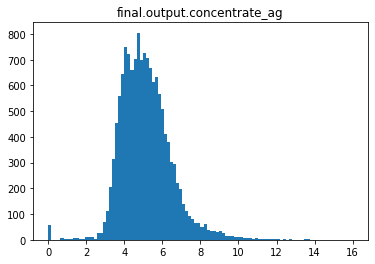

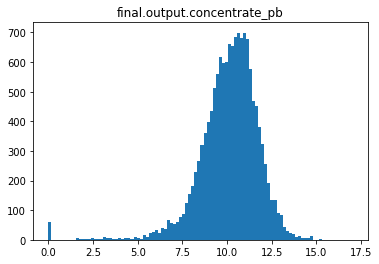

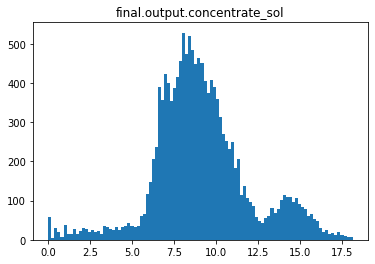

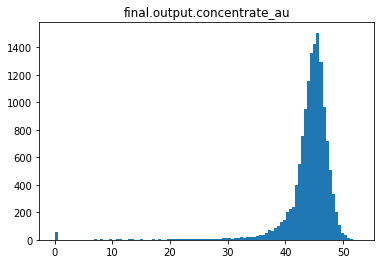

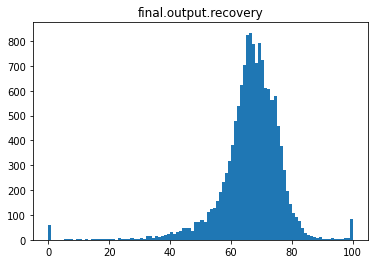

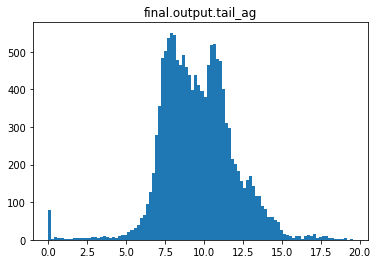

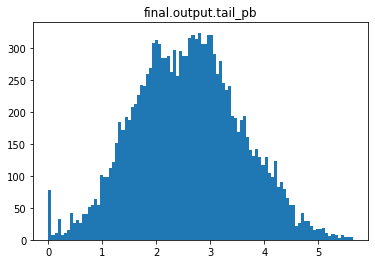

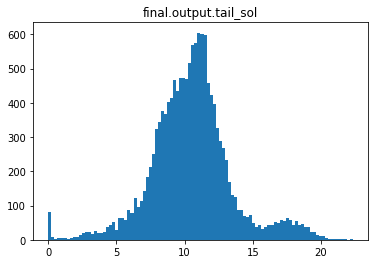

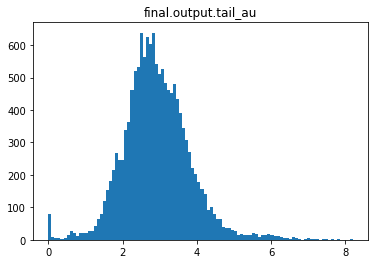

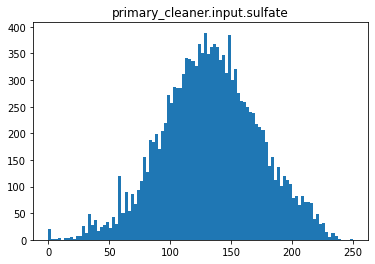

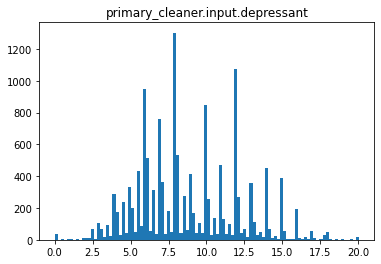

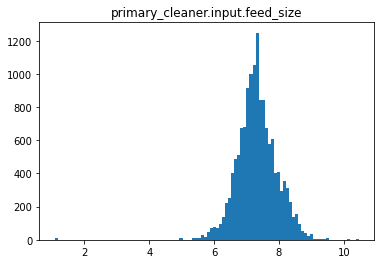

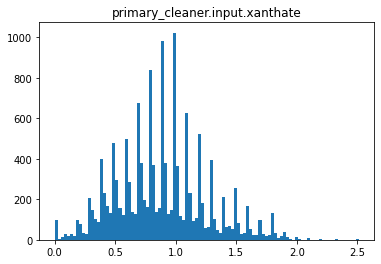

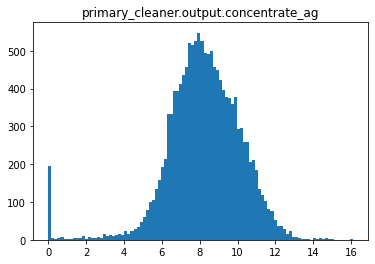

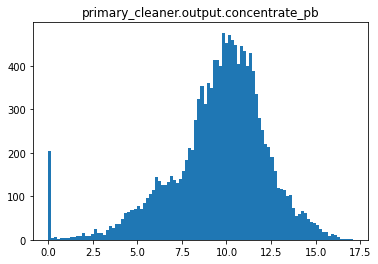

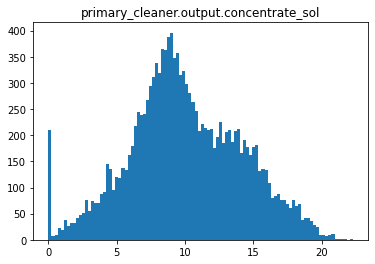

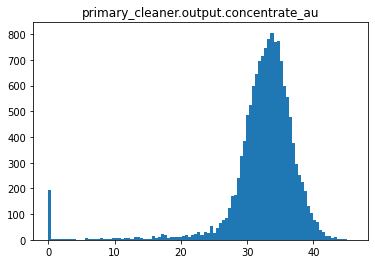

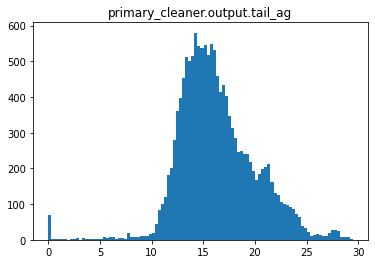

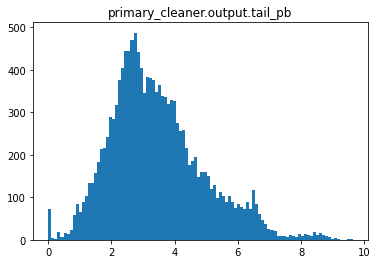

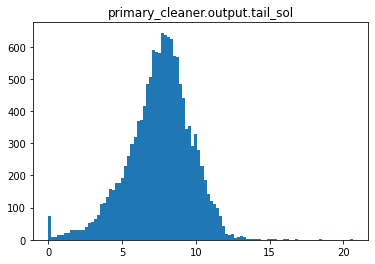

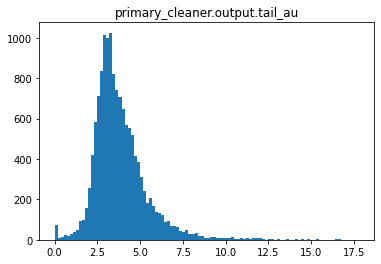

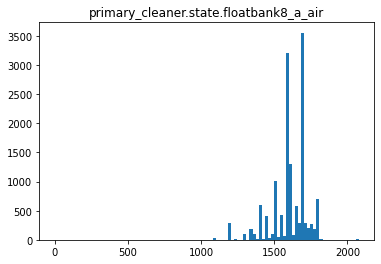

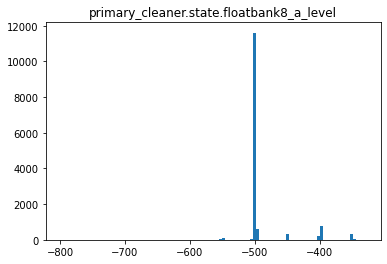

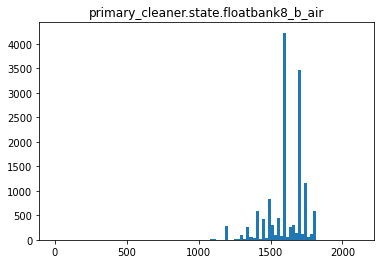

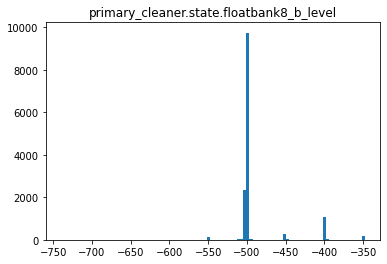

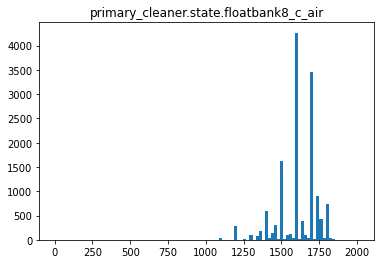

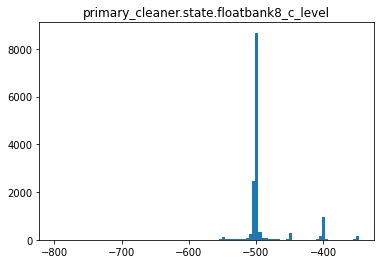

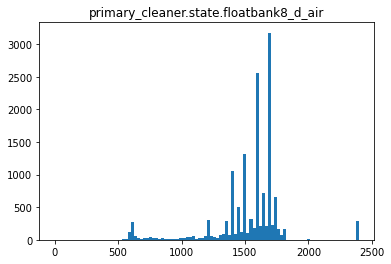

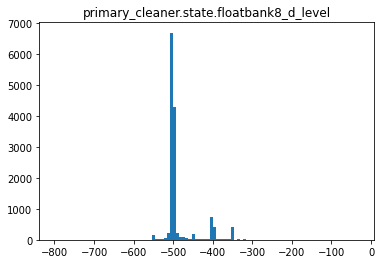

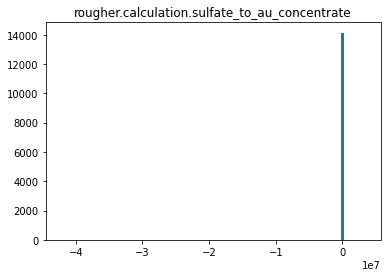

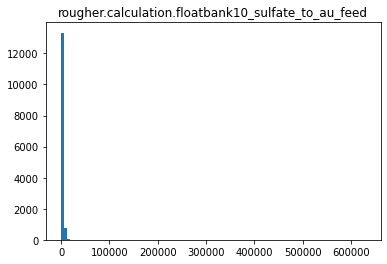

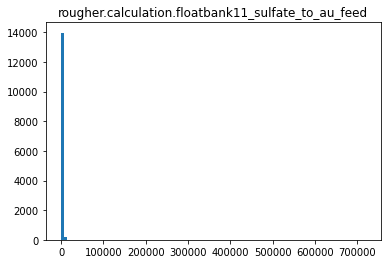

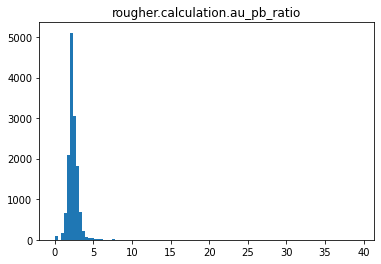

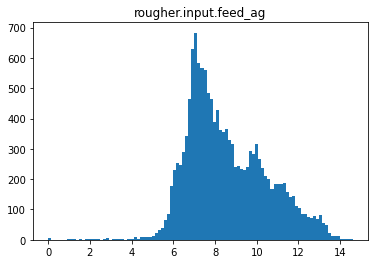

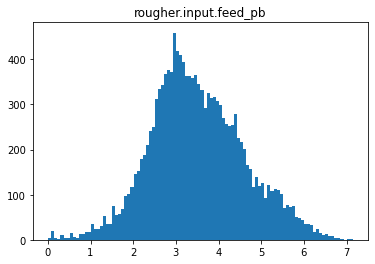

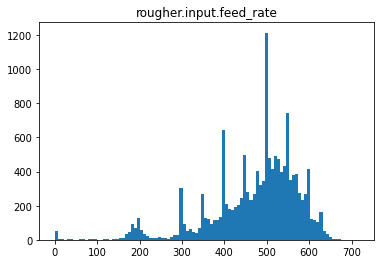

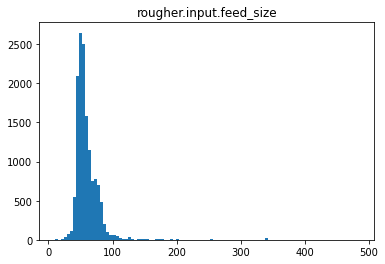

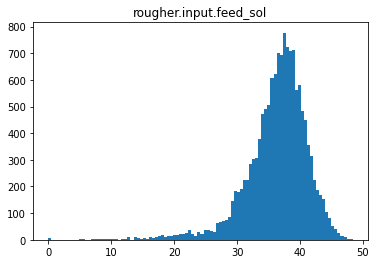

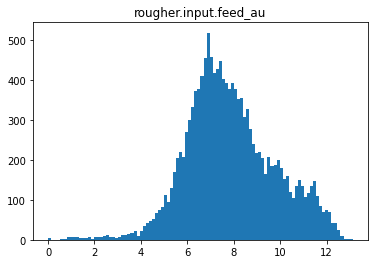

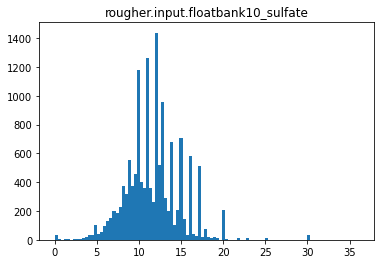

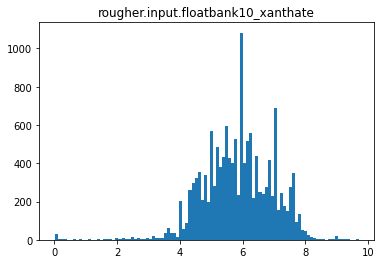

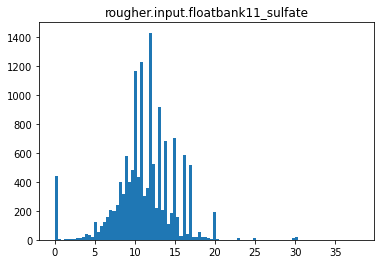

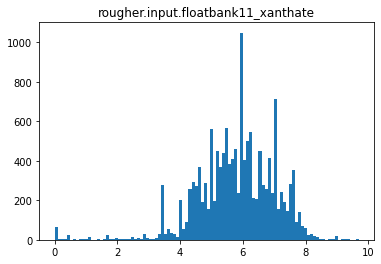

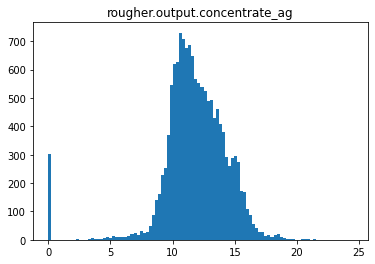

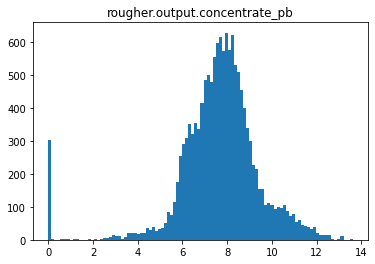

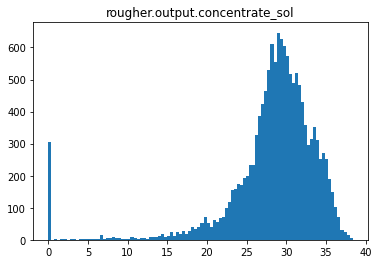

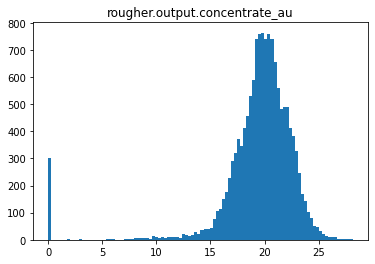

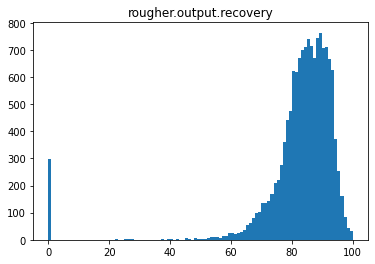

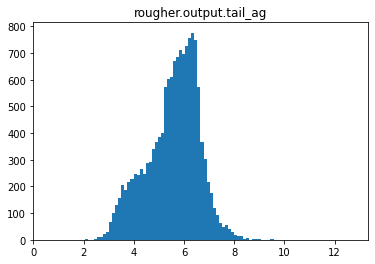

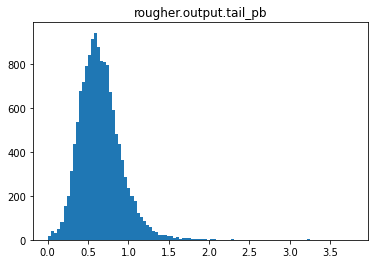

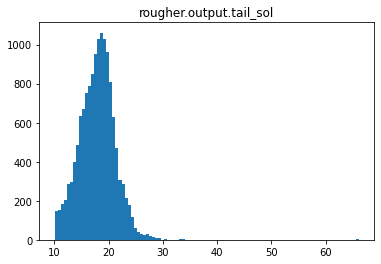

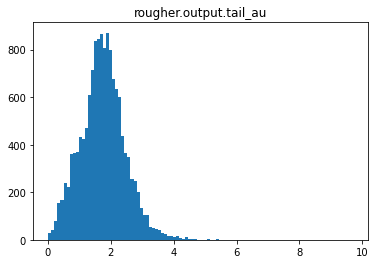

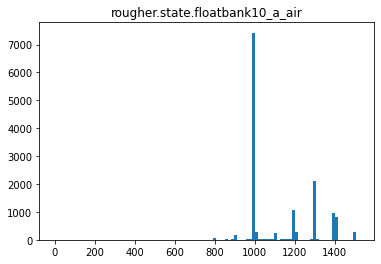

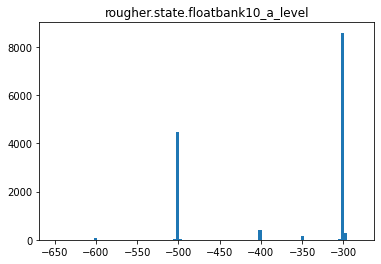

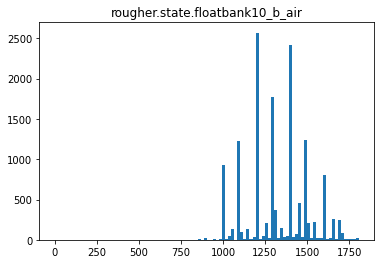

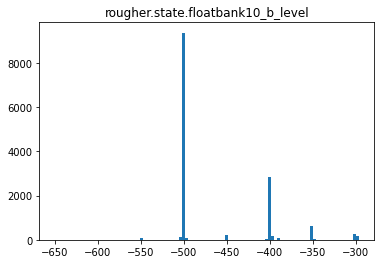

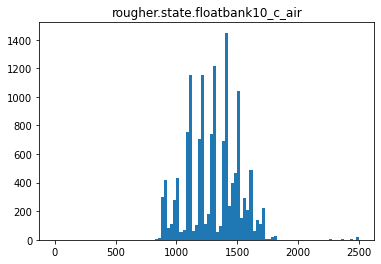

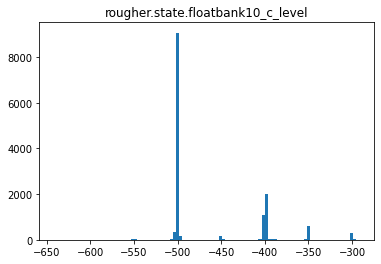

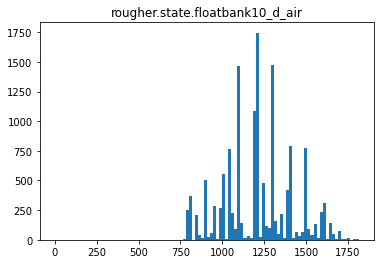

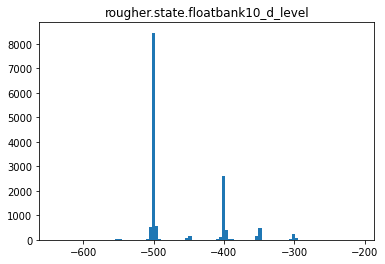

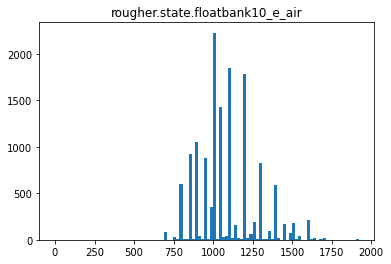

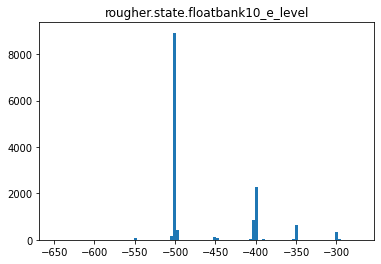

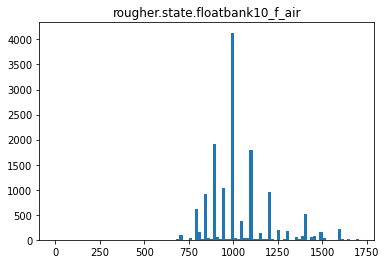

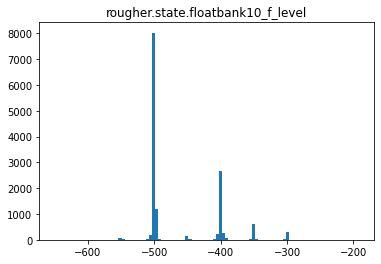

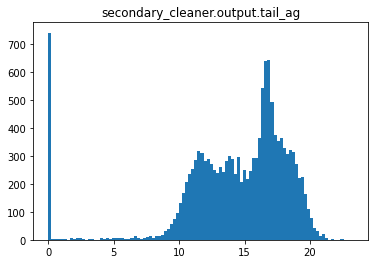

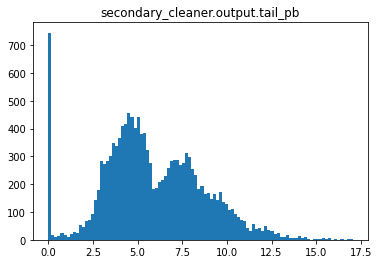

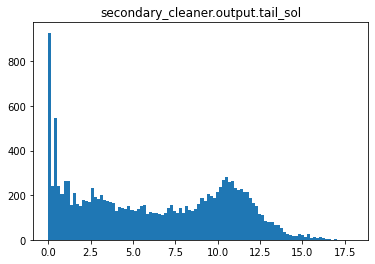

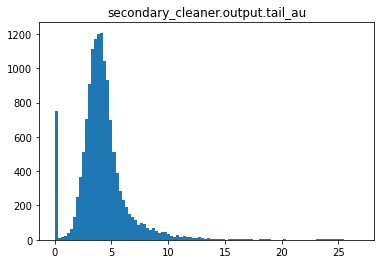

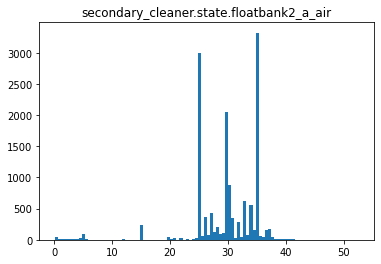

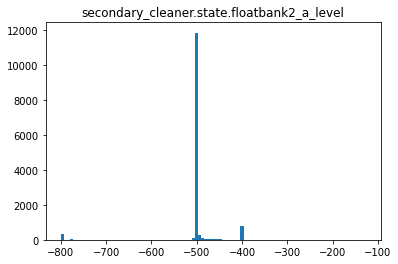

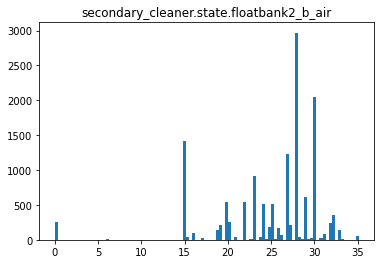

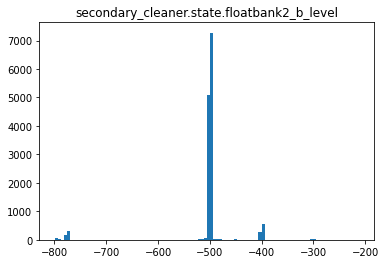

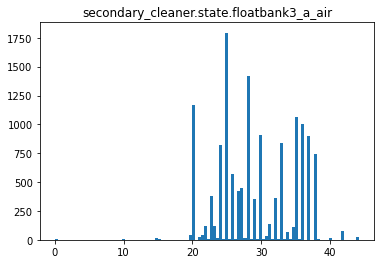

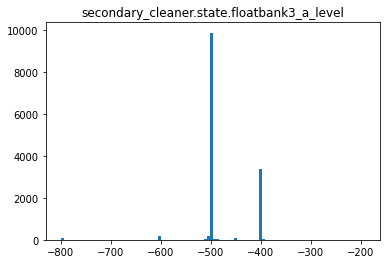

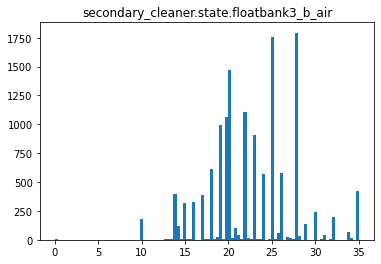

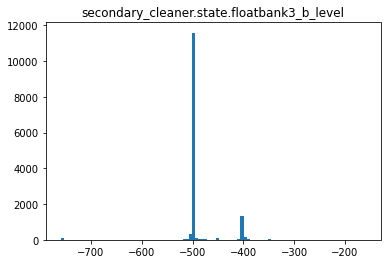

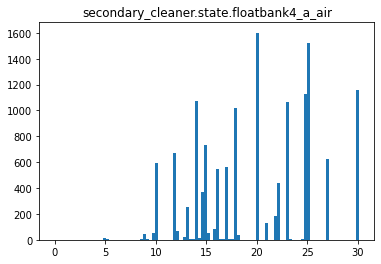

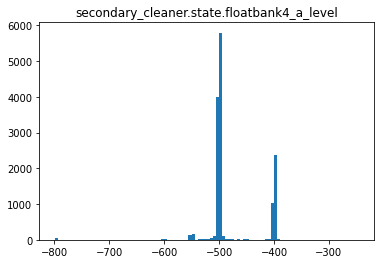

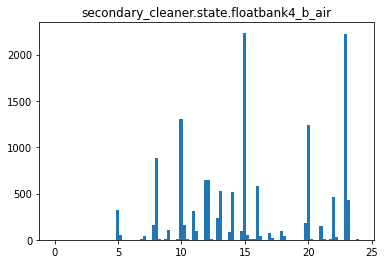

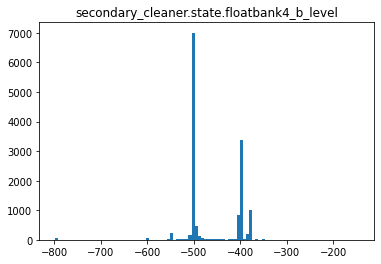

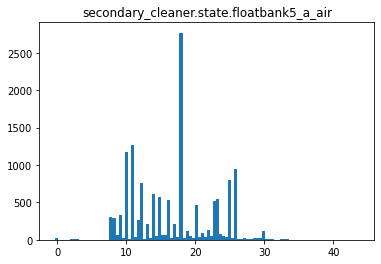

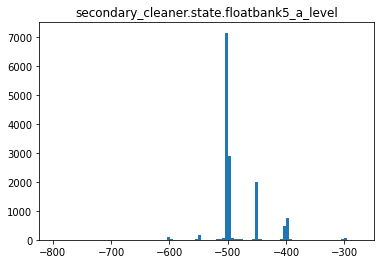

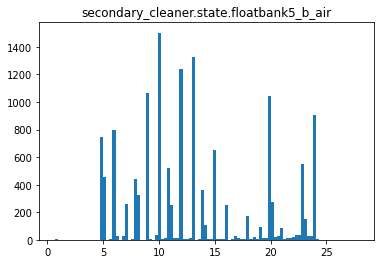

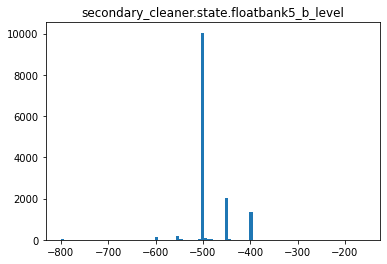

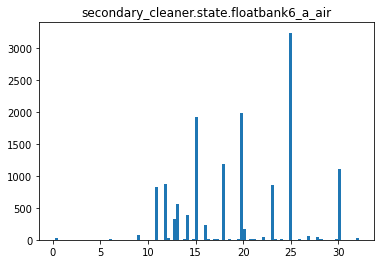

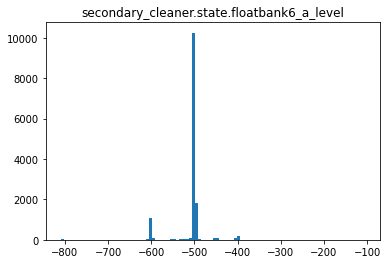

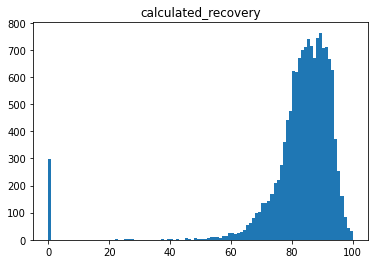

In [29]:
columns = gold_recovery_train.drop(['date'], axis = 1).columns
for column in columns:   
    fig, ax = plt.subplots()
    ax.hist(gold_recovery_train[column], bins = 100)
    ax.set_title(column)
    plt.show()

Отбросим выбросы.

In [30]:
gold_recovery_train_size_before = gold_recovery_train.shape[0]

In [31]:
gold_recovery_train = gold_recovery_train.loc[(gold_recovery_train['final.output.concentrate_ag'] > 0) \
                                              & (gold_recovery_train['final.output.concentrate_pb'] > 0) \
                                              & (gold_recovery_train['final.output.concentrate_sol'] > 0) \
                                              & (gold_recovery_train['final.output.concentrate_au'] > 0) \
                                              & (gold_recovery_train['final.output.tail_ag'] > 0) \
                                              & (gold_recovery_train['final.output.tail_pb'] > 0) \
                                              & (gold_recovery_train['final.output.tail_sol'] > 0) \
                                              & (gold_recovery_train['final.output.tail_au'] > 0) \
                                              & (gold_recovery_train['primary_cleaner.output.concentrate_ag'] > 0.1) \
                                              & (gold_recovery_train['primary_cleaner.output.concentrate_pb'] > 0.1) \
                                              & (gold_recovery_train['primary_cleaner.output.concentrate_sol'] > 0.1) \
                                              & (gold_recovery_train['primary_cleaner.output.concentrate_au'] > 0.1) \
                                              & (gold_recovery_train['primary_cleaner.output.tail_ag'] > 0) \
                                              & (gold_recovery_train['primary_cleaner.output.tail_pb'] > 0) \
                                              & (gold_recovery_train['primary_cleaner.output.tail_sol'] > 0) \
                                              & (gold_recovery_train['primary_cleaner.output.tail_au'] > 0) \
                                              & (gold_recovery_train['rougher.output.concentrate_ag'] > 0) \
                                              & (gold_recovery_train['rougher.output.concentrate_pb'] > 0) \
                                              & (gold_recovery_train['rougher.output.concentrate_sol'] > 0) \
                                              & (gold_recovery_train['rougher.output.concentrate_au'] > 0) \
                                              & (gold_recovery_train['secondary_cleaner.output.tail_ag'] > 0) \
                                              & (gold_recovery_train['secondary_cleaner.output.tail_pb'] > 0) \
                                              & (gold_recovery_train['secondary_cleaner.output.tail_au'] > 0) \
                                             ]

Проверим процент удаленных значений.

In [32]:
(1 - gold_recovery_train.shape[0]/gold_recovery_train_size_before) * 100

9.364619407732

Проверим процент удаленных значений меньше 10.

**Вывод:**
1. Были изучены предоставленные данные.
2. Вычислена эффективность обогащения на обучающей выборке для признака rougher.output.recovery. MAE между расчётами и значением признака небольшая 1.0748911125799084e-14..
3. Проанализированы признаки, недоступные в тестовой выборке. В тестовой выборке отсутствуют параметры продукта (output) и расчётные характеристики (calculation).
4. Проведена предобработку данных. Проверено на наличие дубликатов, дубликаты отсутствуют. Отброшены выбросы, процент удаленных значений меньше 10.

## Анализ данных

2.1 Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

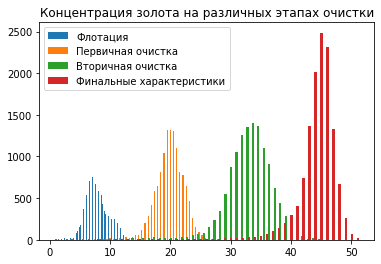

In [33]:
fig, ax = plt.subplots()
ax.hist(gold_recovery_train['rougher.input.feed_au'], bins = 50, rwidth = 0.4, label = 'Флотация')
ax.hist(gold_recovery_train['rougher.output.concentrate_au'], bins = 50, rwidth = 0.4, label = 'Первичная очистка')
ax.hist(gold_recovery_train['primary_cleaner.output.concentrate_au'], bins = 50, rwidth = 0.4, label = 'Вторичная очистка')
ax.hist(gold_recovery_train['final.output.concentrate_au'], bins = 50, rwidth = 0.4, label = 'Финальные характеристики')
ax.set_title('Концентрация золота на различных этапах очистки')
plt.legend()
plt.show()

Концентрация золота на этапах очистки повышается, уменьшается разброс значений.

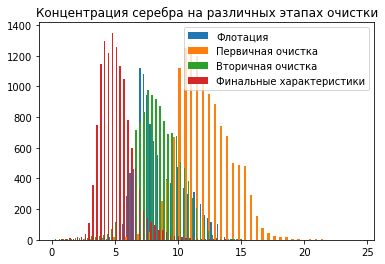

In [34]:
fig, ax = plt.subplots()
ax.hist(gold_recovery_train['rougher.input.feed_ag'], bins = 50, rwidth = 0.4, label = 'Флотация')
ax.hist(gold_recovery_train['rougher.output.concentrate_ag'], bins = 50, rwidth = 0.4, label = 'Первичная очистка')
ax.hist(gold_recovery_train['primary_cleaner.output.concentrate_ag'], bins = 50, rwidth = 0.4, label = 'Вторичная очистка')
ax.hist(gold_recovery_train['final.output.concentrate_ag'], bins = 50, rwidth = 0.4, label = 'Финальные характеристики')
ax.set_title('Концентрация серебра на различных этапах очистки')
plt.legend()
plt.show()

Концентрация серебра после флорации повышается, а на остальных этапах идет на спад. Уменьшается разброс значений.

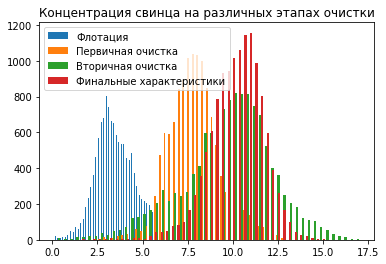

In [35]:
fig, ax = plt.subplots()
ax.hist(gold_recovery_train['rougher.input.feed_pb'], bins = 50, rwidth = 0.4, label = 'Флотация')
ax.hist(gold_recovery_train['rougher.output.concentrate_pb'], bins = 50, rwidth = 0.4, label = 'Первичная очистка')
ax.hist(gold_recovery_train['primary_cleaner.output.concentrate_pb'], bins = 50, rwidth = 0.4, label = 'Вторичная очистка')
ax.hist(gold_recovery_train['final.output.concentrate_pb'], bins = 50, rwidth = 0.4, label = 'Финальные характеристики')
ax.set_title('Концентрация свинца на различных этапах очистки')
plt.legend()
plt.show()

Концентрация свинца на этапах очистки повышается, уменьшается разброс значений.

2.2  Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. 

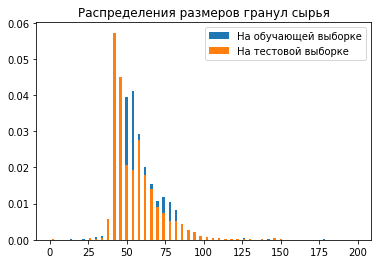

In [36]:
fig, ax = plt.subplots()
ax.hist(gold_recovery_train['rougher.input.feed_size'], bins = 50, range = (0,200), 
        rwidth = 0.4, label = 'На обучающей выборке', density=True)
ax.hist(gold_recovery_test['rougher.input.feed_size'], bins = 50, range = (0,200), 
        rwidth = 0.4, label = 'На тестовой выборке', density=True)
ax.set_title('Распределения размеров гранул сырья')
plt.legend()
plt.show()

Распределения размеров гранул сырья на обучающей и тестовой выборках похожи, варируются в диапазоне 0 - 150, наблюдаются пики в диапазоне 40-60.

2.3 Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

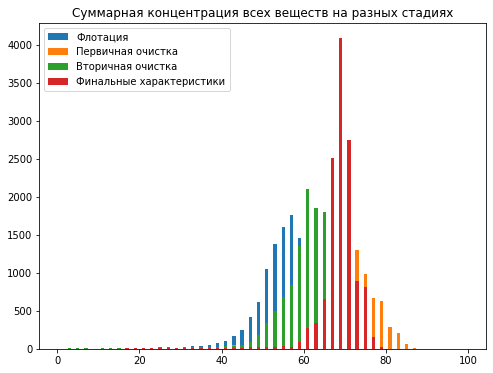

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(gold_recovery_train['rougher.input.feed_au'] + gold_recovery_train['rougher.input.feed_ag'] 
        + gold_recovery_train['rougher.input.feed_pb'] + gold_recovery_train['rougher.input.feed_sol'], 
        bins = 50, range = (0,100), rwidth = 0.4, label = 'Флотация')
ax.hist(gold_recovery_train['rougher.output.concentrate_au'] + gold_recovery_train['rougher.output.concentrate_ag'] 
        + gold_recovery_train['rougher.output.concentrate_pb'] + gold_recovery_train['rougher.output.concentrate_sol'], 
        bins = 50, range = (0,100), rwidth = 0.4, label = 'Первичная очистка')
ax.hist(gold_recovery_train['primary_cleaner.output.concentrate_au'] 
        + gold_recovery_train['primary_cleaner.output.concentrate_ag'] 
        + gold_recovery_train['primary_cleaner.output.concentrate_pb'] 
        + gold_recovery_train['primary_cleaner.output.concentrate_sol'], 
        bins = 50, range = (0,100), rwidth = 0.4, label = 'Вторичная очистка')
ax.hist(gold_recovery_train['final.output.concentrate_au'] + gold_recovery_train['final.output.concentrate_ag'] 
        + gold_recovery_train['final.output.concentrate_pb'] + gold_recovery_train['final.output.concentrate_sol'], 
        bins = 50, range = (0,100), rwidth = 0.4, label = 'Финальные характеристики')
ax.set_title('Суммарная концентрация всех веществ на разных стадиях')
plt.legend()

plt.show()

На каждом этапе гистограмма суммарной концентрации всех веществ возрастает. После каждого этапа количество больших значений уменьшается, уменьшается  разброс значений.

**Вывод:**

1. Проанализировано, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

   Концентрация золота и свинца на этапах очистки повышается. 
   
   Концентрация серебра после флорации повышается, а на остальных этапах идет на спад. 
   
   Уменьшается разброс значений.
   
   
2. Распределения размеров гранул сырья на обучающей и тестовой выборках похожи, варируются в диапазоне 0 - 150, наблюдаются пики в диапазоне 40-60.


3. На каждом этапе гистограмма суммарной концентрации всех веществ возрастает. После каждого этапа количество больших значений уменьшается, уменьшается разброс значений.

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'> Всё верно!</font>

## Модель

3.1 Напишем функцию для вычисления итоговой sMAPE.

In [38]:
def sMAPE(target, prediction):
    return sum(abs(target-prediction)/((abs(target) + abs(prediction))/2)*100)/len(target)

In [39]:
scorer_sMAPE = make_scorer(sMAPE)

3.2. Обучим разные модели и оцените их качество кросс-валидацией. 

Из обучающей выборки получим только те столбцы, которые есть в тестовой. Разделим данные на целивой признак и остальные. 

In [40]:
features_gold_recovery_train = gold_recovery_train[gold_recovery_test.columns].drop(['date'],axis=1)
target_gold_recovery_train_final = gold_recovery_train['final.output.recovery']
target_gold_recovery_train_rougher = gold_recovery_train['rougher.output.recovery']

Приведем численные признаки к одному масштабу.

In [41]:
scaler = StandardScaler()
scaler.fit(features_gold_recovery_train)
features_gold_recovery_train = scaler.transform(features_gold_recovery_train)

Построим модель с использованием логической регрессии.

In [42]:
model_for_rougher = LinearRegression()
scores = cross_val_score(model_for_rougher, features_gold_recovery_train, target_gold_recovery_train_rougher, cv=5, scoring = scorer_sMAPE) 
scores.mean()

7.506579758900858

In [43]:
model_for_final = LinearRegression()
scores = cross_val_score(model_for_final, features_gold_recovery_train, target_gold_recovery_train_final, scoring = scorer_sMAPE, cv=5) 
scores.mean()

11.014789112180418

Построим модель с использованием алгоритма дерева решений.

In [44]:
best_score = 10000
best_depth = 0
best_model = None

for depth in range(1,10):
    model = DecisionTreeRegressor(random_state=12345, max_depth = depth)
    scores = cross_val_score(model, features_gold_recovery_train, target_gold_recovery_train_rougher, cv=5, scoring = scorer_sMAPE) 
    
    if(scores.mean() < best_score):
            best_score = scores.mean()
            best_depth = depth
            best_model = model
            
print(best_score)
print(best_depth)

7.186705754358266
4


In [45]:
best_score = 10000
best_depth = 0
best_model = None

for depth in range(1,10):
    model = DecisionTreeRegressor(random_state=12345, max_depth = depth)
    scores = cross_val_score(model, features_gold_recovery_train, target_gold_recovery_train_final, cv=5, scoring = scorer_sMAPE) 
    
    if(scores.mean() < best_score):
            best_score = scores.mean()
            best_depth = depth
            best_model = model
            
print(best_score)
print(best_depth)

9.127567219894702
3


Построим модель с использованием алгоритма случайного леса.

In [46]:
best_score = 10000
best_depth = 0
best_n_estimator = 0
best_model = None

for n_estimator in range(20, 40, 10):
    for depth in range(1, 7, 1):
        model = RandomForestRegressor(n_estimators=n_estimator, max_depth=depth, random_state=12345)
        scores = cross_val_score(model, features_gold_recovery_train, target_gold_recovery_train_rougher, cv=5, scoring = scorer_sMAPE) 

        if(scores.mean() < best_score):
            best_score = scores.mean()
            best_depth = depth
            best_n_estimator = n_estimator
            best_model = model
        
print(best_score)
print(best_depth)
print(best_n_estimator) 

6.271370066640719
5
30


In [47]:
best_score = 10000
best_depth = 0
best_n_estimator = 0
best_model = None

for n_estimator in range(20, 40, 10):
    for depth in range(1, 7, 1):
        model = RandomForestRegressor(n_estimators=n_estimator, max_depth=depth, random_state=12345)
        scores = cross_val_score(model, features_gold_recovery_train, target_gold_recovery_train_final, cv=5, scoring = scorer_sMAPE) 

        if(scores.mean() < best_score):
            best_score = scores.mean()
            best_depth = depth
            best_n_estimator = n_estimator
            best_model = model
        
print(best_score)
print(best_depth)
print(best_n_estimator) 

8.928210444275354
2
20


Наилучшие результаты для признака 'rougher.output.recovery' показала модель RandomForestRegressor(n_estimators=30, max_depth=5, random_state=12345), а для признака 'final.output.recovery' - RandomForestRegressor(n_estimators=20, max_depth=2, random_state=12345).

3.3 Проверка на тестовой выборке

In [48]:
features_gold_recovery_test = gold_recovery_test.drop(['date'],axis=1)
target_gold_recovery_test_final = gold_recovery_full.loc[gold_recovery_full['date'].isin(gold_recovery_test['date']),'final.output.recovery']
target_gold_recovery_test_rougher = gold_recovery_full.loc[gold_recovery_full['date'].isin(gold_recovery_test['date']),'rougher.output.recovery']

Приведем численные признаки к одному масштабу.

In [49]:
features_gold_recovery_test = scaler.transform(features_gold_recovery_test) 

Обучим модели, сравним предсказанные значения с константной моделью.

In [50]:
model = RandomForestRegressor(n_estimators=30, max_depth=5, random_state=12345)
model.fit(features_gold_recovery_train, target_gold_recovery_train_rougher)
predicted_rougher = model.predict(features_gold_recovery_test)
sMAPE(target_gold_recovery_test_rougher, predicted_rougher)

8.223892526585217

In [51]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(features_gold_recovery_train, target_gold_recovery_train_rougher)
predicted = dummy_regr.predict(features_gold_recovery_test)
sMAPE(target_gold_recovery_test_rougher, predicted)

8.64127051346479

sMAPE модели RandomForestRegressor(n_estimators=30, max_depth=5, random_state=12345) показал результат лучше, чем константная модель.

In [52]:
model = RandomForestRegressor(n_estimators=20, max_depth=2, random_state=12345)
model.fit(features_gold_recovery_train, target_gold_recovery_train_final)
predicted_final = model.predict(features_gold_recovery_test)
sMAPE(target_gold_recovery_test_final, predicted_final) 

9.136667659992522

In [53]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(features_gold_recovery_train, target_gold_recovery_train_final)
predicted = dummy_regr.predict(features_gold_recovery_test)
sMAPE(target_gold_recovery_test_final, predicted) 

9.783541199248917

sMAPE модели RandomForestRegressor(n_estimators=20, max_depth=2, random_state=12345) показал результат лучше, чем константная модель.

Итоговое sMAPE

In [54]:
0.25 * sMAPE(target_gold_recovery_test_rougher, predicted_rougher) + 0.75 * sMAPE(target_gold_recovery_test_final, predicted_final) 

8.908473876640695

**Вывод:**
1. Написана функция для вычисления итоговой sMAPE.
2. Обучены модели с использованием логической регрессии, дерева решений и случайного леса и оценено их качество кросс-валидацией. Наилучшие результаты для признака 'rougher.output.recovery' показала модель RandomForestRegressor(n_estimators=30, max_depth=5, random_state=12345), а для признака 'final.output.recovery' - RandomForestRegressor(n_estimators=20, max_depth=2, random_state=12345).
3. Проверены наилучшие модели на тестовой выборке. sMAPE модели RandomForestRegressor(n_estimators=30, max_depth=5, random_state=12345) и модели RandomForestRegressor(n_estimators=20, max_depth=2, random_state=12345) показали результат лучше, чем константная модель. Итоговое sMAPE 8.9.

## Общий вывод

1. Подготовка данных

    1.1 Были изучены предоставленные данные.
    
    1.2. Вычислена эффективность обогащения на обучающей выборке для признака rougher.output.recovery. MAE между расчётами и значением признака небольшая 1.0748911125799084e-14.
    
    1.3. Проанализированы признаки, недоступные в тестовой выборке. В тестовой выборке отсутствуют параметры продукта (output) и расчётные характеристики (calculation).
    
    1.4. Проведена предобработку данных. Проверено на наличие дубликатов, дубликаты отсутствуют. Отброшены выбросы, процент удаленных значений меньше 10.
    
2. Анализ данных

    2.1. Проанализировано, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.
        Концентрация золота и свинца на этапах очистки повышается. 
        Концентрация серебра после флорации повышается, а на остальных этапах идет на спад. 
        Уменьшается разброс значений.

    2.2. Распределения размеров гранул сырья на обучающей и тестовой выборках похожи, варируются в диапазоне 0 - 150, наблюдаются пики в диапазоне 40-60.

    2.3. На каждом этапе гистограмма суммарной концентрации всех веществ возрастает. После каждого этапа количество больших значений уменьшается, уменьшается разброс значений.
    

3. Построение модели прогнозирования

    3.1. Написана функция для вычисления итоговой sMAPE.
    
    3.2. Обучены модели с использованием логической регрессии, дерева решений и случайного леса и оценено их качество кросс-валидацией. Наилучшие результаты для признака 'rougher.output.recovery' показала модель RandomForestRegressor(n_estimators=30, max_depth=5, random_state=12345), а для признака 'final.output.recovery' - RandomForestRegressor(n_estimators=20, max_depth=2, random_state=12345).
    
    3.3. Проверены наилучшие модели на тестовой выборке. sMAPE модели RandomForestRegressor(n_estimators=30, max_depth=5, random_state=12345) и модели RandomForestRegressor(n_estimators=20, max_depth=2, random_state=12345) показали результат лучше, чем константная модель. Итоговое sMAPE 8.9.